In [1]:
import pickle, os

home_dir = "../data"

charge_off_classifier_core_pkl = os.path.join(home_dir, "co_clf_core.pkl")
#charge_off_classifier_core_pkl = os.path.join(home_dir, "test2.pkl")


with open(charge_off_classifier_core_pkl,'rb') as f:
    data_df, idx_train, idx_test, idx_validate, clf_core, core_features, analytics = pickle.load(f)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
import operator
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline
from datetime import date,timedelta

import matplotlib.ticker as tkr
from matplotlib import rcParams

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import date,timedelta

In [3]:
# Define train, test, and validate df
train_df    = data_df.loc[idx_train, :]
test_df     = data_df.loc[idx_test, :]
validate_df = data_df.loc[idx_validate, :]

print("Number of loans in Train    set: {}".format(train_df.shape[0]))
print("Number of loans in Test     set: {}".format(test_df.shape[0]))
print("Number of loans in Validate set: {}".format(validate_df.shape[0]))

Number of loans in Train    set: 553049
Number of loans in Test     set: 97597
Number of loans in Validate set: 650647


In [4]:
print(validate_df.columns)

Index(['loan_amnt', 'term', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'collections_12_mths_ex_med',
       'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens'

# Simulation Functions

In [5]:
#record the delay according to delay parameter
def loss(row, loss, delay):
    n = int( row["month"] + delay)
    l = row["loss"]
    loss[n] += l

In [6]:
def generate_series(invested_df, loss_delay, diversification_ratio, N = 60):
    
    #create payments df given current investment
    df = pd.DataFrame(invested_df.apply(payments, axis=1).to_list(), columns=["int","prn","month", "loss"])

    #seperate interest and principle from the df
    int_series = pd.DataFrame(df["int"].to_list()).fillna(value=0).aggregate(sum, axis=0).to_list()
    prn_series = pd.DataFrame(df["prn"].to_list()).fillna(value=0).aggregate(sum, axis=0).to_list()
    
    #apply diversification ratio
    int_series = [i * diversification_ratio for i in int_series]
    prn_series = [i * diversification_ratio for i in prn_series]
    
    #padding zero
    int_series += [0]*(N - len(int_series))
    prn_series += [0]*(N - len(prn_series))

    #create loss series
    loss_series = np.zeros(N + loss_delay)
    df.apply(loss, axis=1, args=(loss_series, loss_delay))
    
    #apply diversification ratio to loss as well
    loss_series = [i * diversification_ratio for i in loss_series]
    
    return int_series, prn_series, loss_series

In [7]:
#calculate payments for each loans
def payments(row):
    rate  = float( row['int_rate']/100 )
    rate /= float(12)
    N = int(row['term'])
    if N == 0:
        N = 36
    else:
        N = 60
    
    #load loan parameters
    L = row['funded_amnt']   
    install = row['installment']  
    total_rec_int = row['total_rec_int']
    total_rec_prncp = row['total_rec_prncp']
    recoveries = row['recoveries']
    total_pymnt = row['total_pymnt']
    life_of_loan = int(row['LifeOfLoan'])
    charged_off = (row['LoanStatus'] == 1.0)
    
    int_rec = []
    prn_rec = []
    prn_rem = []
    
    P = L
    tot_int = 0
    tot_prn = 0
    tot_rec = 0
  
    for n in range(N):
      
        # Normal payments
        int_pmnt = P*rate
        prn_pmnt = install - int_pmnt

        # End of interest payments is termination condition
        if not (int_pmnt + tot_int) < total_rec_int:
            #message = "Interest payments terminated"
            int_pmnt = total_rec_int - tot_int
            if (int_pmnt < 0):
             #   print("int neg 1")
                int_rec[-1] += int_pmnt
                break
            prn_pmnt = total_rec_prncp - tot_prn
            tot_int += int_pmnt
            tot_prn += prn_pmnt
            int_rec.append(int_pmnt)
            prn_rec.append(prn_pmnt)
            
            break
 
        # In default, last few payments are considered interest?
        if not (prn_pmnt + tot_prn) < total_rec_prncp:
            prn_pmnt = total_rec_prncp - tot_prn
            int_pmnt = install - prn_pmnt
            
        tot_int += int_pmnt
        tot_prn += prn_pmnt
        
               
        P -= prn_pmnt

        int_rec.append(int_pmnt)
        prn_rec.append(prn_pmnt)
        

    loss = L - tot_prn + recoveries
    
    return int_rec, prn_rec, n, loss

## Dynamic portfolio management function

In [8]:
def check_status(term_ratio,current_df,optimal_threshold):
    #exception catch
    if len(current_df) == 0:
        longer_loan = 0
        risk_loan = 0
        return longer_loan,risk_loan
    
    else:
        #calculate average score
        current_score = current_df['score'].sum()/len(current_df)
        #if current average score is greater than half of our optimal_threshold, we will choose relatively more risky loan next period
        if current_score > 0.5 * optimal_threshold:
            risk_loan = 0
        else:
            risk_loan = 1

        #calculate term structue of current portfolio    
        current_three_year = len(current_df.loc[current_df['term']==0])
        current_five_year = len(current_df) - current_three_year
        if current_five_year ==0:
            ratio = 20
        else:
            ratio = current_three_year / current_five_year
        if ratio > term_ratio:
            longer_loan = 1
        else:
            longer_loan = 0

        return longer_loan,risk_loan

In [26]:
def evaluate_invest(dynamic_management,term_ratio,past_investment,current_date,sample_df, max_leverage_capital, optimal_threshold, \
                    optimal_diversification_ratio):
    #exception catch
    if len(past_investment) == 0:
        longer_loan = 0
        risk_loan = 0
        current_df = past_investment.copy()
    else:
        #check current portfolio parameters
        current_df = past_investment.loc[past_investment['issue_d'] + pd.to_timedelta(past_investment['LifeOfLoan'], unit='M') > current_date]
        longer_loan,risk_loan = check_status(term_ratio,current_df,optimal_threshold)
    
    #select loans that below our default threshold
    selected_df = sample_df.loc[sample_df.score < optimal_threshold, :]
    
    #apply diversification ratio
    max_leverage_capital2 = max_leverage_capital / optimal_diversification_ratio
    
    invested_df = selected_df.copy()
        
    #check each loans in our investment df that whether it suits the requirement of check_status
    if dynamic_management:
        for index, row in invested_df.iterrows(): 
            if len(current_df) != 0:
                current_score = current_df['score'].sum()/len(current_df)
            else: 
                current_score = 0.5*optimal_threshold
            if max_leverage_capital2 - row['loan_amnt'] > 0:
                if longer_loan == 1:
                    if risk_loan == 1:
                        if (row['score'] < current_score) or (row['term'] == 0):
                            invested_df = invested_df.drop(index)
                        else:
                            max_leverage_capital2 -= row['loan_amnt']
                            current_df = current_df.append(row)
                            longer_loan,risk_loan = check_status(term_ratio,current_df,optimal_threshold)
                    else:
                        if (row['score'] > current_score) or (row['term'] == 0):
                            invested_df = invested_df.drop(index)
                        else:
                            max_leverage_capital2 -= row['loan_amnt']
                            current_df = current_df.append(row)
                            longer_loan,risk_loan = check_status(term_ratio,current_df,optimal_threshold)
                else:
                    if risk_loan == 1:
                        if (row['score'] < current_score) or (row['term'] == 1):
                            invested_df = invested_df.drop(index)
                        else:
                            max_leverage_capital2 -= row['loan_amnt']
                            current_df = current_df.append(row)
                            longer_loan,risk_loan = check_status(term_ratio,current_df,optimal_threshold)
                    else:
                        if (row['score'] > current_score) or (row['term'] == 1):
                            invested_df = invested_df.drop(index)
                        else:
                            max_leverage_capital2 -= row['loan_amnt']
                            current_df = current_df.append(row)
                            longer_loan,risk_loan = check_status(term_ratio,current_df,optimal_threshold)
            else:
                invested_df = invested_df.drop(index)
    else:
        if selected_df['loan_amnt'].sum() * optimal_diversification_ratio > max_leverage_capital:
            invested_df = selected_df.loc[selected_df['loan_amnt'].cumsum() <= max_leverage_capital2, :]
            current_df = current_df.append(invested_df)
        else:
            invested_df = selected_df.copy()
            current_df = current_df.append(invested_df)

    return current_df,invested_df,selected_df


In [27]:
def plot_bank_run(date_series,dyn_params, opt_params, equity, income, losses, assets, bankrupt):
    # figure size in inches
    rcParams['figure.figsize'] = 16,9
    rcParams['font.size'] = 16

    plt.tight_layout()


    N = len(equity)
    if bankrupt:
        N -= 1
        equity = equity[:N]
        income  = income[:N]
        losses  = losses[:N]
        assets  = assets[:N]

    ax = plt.subplot()
    ax.plot(date_series, equity, 'g', label='Capital', )
    ax.plot(date_series, income,  'c', label='Income')
    ax.plot(date_series, losses,  'r', label='Losses')
#     ax.set_ylim([0,25000000])
    ax.yaxis.set_major_formatter(tkr.StrMethodFormatter('${x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MultipleLocator(4))
    ax.legend()

    plt.title("Lending Club bank: {0:.0f}Y performance \n Threshold {1:.3f}, leverage {2:2d}:1, diversification_ratio {3:.2f}, Loss delay {4:d}M".format(N/4, opt_params['threshold'], \
            opt_params['leverage_ratio'],opt_params['diversification_ratio'],opt_params['loss_delay']))


    plt.xlabel("Quarters")
    plt.show()

In [29]:
def bank_run(start_date, sample_params, opt_params, do_print=False, do_plot=False):
    total_income = []
    total_invested = []
    
    date_delta = sample_params['inv_cycle'] * 30
    date_range = date_delta * sample_params['length_of_run'] / sample_params['inv_cycle']-1
    end_date = start_date+timedelta(date_range)
    delta = timedelta(date_delta)
    
    #Balance sheet terms
    BS_cash = []
    BS_investment = []
    BS_debt = []
    BS_equity = []
    
    BS_cash_term = 0
    BS_investment_term = 0
    BS_debt_term = 0
    BS_equity_term = 0
    
    # sampled loans
    df_list = sample_params['sample_df_list']
    
    # Initial cash,investment,debt, and equity
    BS_cash_term = opt_params['starting_capital']
    BS_investment_term = 0
    BS_debt_term = 0
    BS_equity_term = BS_cash_term + BS_investment_term - BS_debt_term
    
    
    

    # BS series to output
    cash_series   = []
    investment_seires = []
    asset_series = []
    debt_series = []
    equity_series =[]
    
    # IS series
    income_series  = []
    losses_series  = []

    # Metrics series
    new_loan_series = []
    
    #Income Statement terms
    IS_interest_receive = []
    IS_interest_pay = []
    IS_loss_recognized = []
    IS_net_income = []
    
    IS_interest_receive_term = 0
    IS_interest_pay_term = 0
    IS_loss_recognized_term = 0
    IS_net_income_term = 0
    
    #output terms
    cash_series   = []
    investment_seires = []
    asset_series = []
    debt_series = []
    equity_series =[]

    date_series= []
    payment_series = []
    leverage_series = []
    
    total_selected_amnt = []
    num_of_selected_loans = []
    num_of_default_loans = []
    num_of_36_months = []
    num_of_60_months = []
    
    # Monthly rate on loan
    rate_3M  = (sample_params['inv_cycle'] / 12) * (opt_params['loan_interest_rate']/100 )

    # Set up data structures
    # interest_income, principal_pymt are 180 * 0, loss_recognized is 183 * 0
    interest_income = np.zeros(sample_params['length_of_run']+60)
    principal_pymnt = np.zeros(sample_params['length_of_run']+60)
    loss_recognized = np.zeros(sample_params['length_of_run'] + opt_params['loss_delay'] + 60)

    
    # Initial values for run
    old_loan   = 0
    old_d  = 0
    n = 0
    d = sample_params['inv_cycle']
    bankrupt = False
    term_ratio = opt_params['term_ratio']
    dynamic_management = opt_params['dynamic_management']
    
    past_investment = pd.DataFrame()

    while start_date < end_date:
        
        
        print ("Period ",n, " Date ", start_date)
        
        if do_print:
            print ('initial cash', BS_cash_term)
            print ('initial investment', BS_investment_term)
            print ('initial debt', BS_debt_term)
            print ('initial equity',BS_equity_term) 
            
        new_loan = opt_params['leverage_ratio'] * BS_equity_term
        temp_cash = BS_cash_term
        temp_cash += new_loan
        temp_cash -= old_loan
        max_leverage_capital = max(0, temp_cash)
        
        #print log
        if do_print:
            print ('max_leverage', max_leverage_capital)
            print ('old_loan', BS_debt_term)
        

        current_df,invested_df, selected_df = evaluate_invest(dynamic_management,term_ratio,past_investment,start_date, df_list[n], max_leverage_capital,opt_params['threshold'],opt_params['diversification_ratio'])
        
        new_loan = max(invested_df['loan_amnt'].sum()* opt_params['diversification_ratio']-BS_cash_term+old_loan,0)
        leverage = round(new_loan/BS_equity_term,1)
        
    
        BS_cash_term += new_loan
        BS_debt_term += new_loan

#        Pay back old loan

        BS_cash_term -= old_loan
        BS_debt_term -= old_loan
        
        past_investment = current_df.copy()
        
        if do_print:
            print ('After financing cash', BS_cash_term)
            print ('After financing investment', BS_investment_term)
            print ('After financing debt', BS_debt_term)
            print ('After financing equity',BS_equity_term)            
            print ('borrow amount', new_loan)
            print ('current leverage',leverage) 

            
        old_loan  = new_loan
        
        n+=1
        
        leverage_series.append(leverage)
        
        # Total actually invested
        invested = invested_df['loan_amnt'].sum()*opt_params['diversification_ratio']
        # Update cash balance
        
        BS_cash_term -= invested
        BS_investment_term += invested
        
        if do_print:
            print ('investment amount', invested)
            print ('after investment cash', BS_cash_term)
            print ('after investment investment', BS_investment_term)
            print ('after investment debt', BS_debt_term)
            print ('after investment equity',BS_equity_term)
        
        #record result_list item
        tot_select_amnt = invested_df['loan_amnt'].sum()
        total_selected_amnt.append(tot_select_amnt)
        num_of_loans = invested_df.shape[0]
        num_of_selected_loans.append(num_of_loans)
        
        df_36m = 0
        df_60m = 0
        df_charged_off = 0
        for t in range(num_of_loans):
            tmp = invested_df.iloc[t,:]
            if tmp.loc['term'] == 0:
                df_36m += 1
            else:
                df_60m += 1
            if tmp.loc['LoanStatus'] == 1:
                df_charged_off += 1
        num_of_default_loans.append(df_charged_off)
        num_of_36_months.append(df_36m)
        num_of_60_months.append(df_60m)
        

        # Calculate outcomes of new investment
        if (len(invested_df) == 0):
            int_series = 0
            prn_series = 0
            lss_series = 0
        else:
            int_series, prn_series, lss_series = generate_series(invested_df, \
                        opt_params['loss_delay'],opt_params['diversification_ratio'])
        temp = []
        temp.append(int_series)
        temp.append(prn_series)
        temp.append(lss_series)
        
        if not (len(invested_df) == 0):
        # Add new outcomes to tails of old outcomes
            interest_income[old_d: len(int_series) + old_d] += int_series
            principal_pymnt[old_d: len(prn_series) + old_d] += prn_series
            loss_recognized[old_d: len(lss_series) + old_d] += lss_series


        # Calculate interest, principal, losses from old_d to d
        int_calc = interest_income[old_d:old_d+d].sum()
        prn_calc = principal_pymnt[old_d:old_d+d].sum()
        loss_calc = loss_recognized[old_d:old_d+d].sum()

        if do_print:
            print ('Int_received',int_calc)
            print ('Principle_received',prn_calc)
            print ('Loss_calc',loss_calc)
        
        
        # Loan interest due
        int_loan = new_loan * (rate_3M)

        if do_print:
            print ('int_loan',int_loan)
            

        
        if do_print: 
            print ('after_interest_cash',BS_cash_term)
        

        BS_cash_term += int_calc
        BS_equity_term +=int_calc
        
        BS_cash_term += prn_calc
        BS_investment_term -= prn_calc
        
        
        BS_cash_term -= int_loan
        BS_equity_term -= int_loan
        

        BS_investment_term -= loss_calc
        BS_equity_term -= loss_calc
        
        if do_print:
            print ('end cash', BS_cash_term)
            print ('end investment', BS_investment_term)
            print ('end debt', BS_debt_term)
            print ('end equity',BS_equity_term)
        
     
        BS_cash.append(BS_cash_term)
        BS_investment.append(BS_investment_term)
        BS_debt.append(BS_debt_term)
        BS_equity.append(BS_equity_term)



        


        IS_interest_receive_term = int_calc
        IS_interest_pay_term = int_loan
        IS_loss_recognized_term = loss_calc
        IS_net_income_term = IS_interest_receive_term - IS_interest_pay_term - IS_loss_recognized_term

        IS_interest_receive.append(IS_interest_receive_term)
        IS_interest_pay.append(IS_interest_pay_term)
        IS_loss_recognized.append(IS_loss_recognized_term)
        IS_net_income.append(IS_net_income_term)




        # Record
            # BS series to output
        asset_series.append(BS_cash_term+BS_investment_term)
        equity_series.append(BS_equity_term)
        cash_series.append(BS_cash_term)
        investment_seires.append(BS_investment_term)
        debt_series.append(BS_debt_term)
        income_series.append(int_calc - int_loan)
        losses_series.append(loss_calc)
        
        
        new_loan_series.append(new_loan)
        
        payment_series.append(temp)

        # Bankrupt!
        if BS_equity_term < 0:
            bankrupt = True
            print("Bankrupt!")
            break

        # Update
        
        old_d += d
        start_date += delta
        temp_date = start_date.strftime("%Y-%m")
        date_series.append(temp_date)
   
    
        print (" ")
        
    if do_plot:
        plot_bank_run(date_series,sample_params, opt_params, equity_series, income_series, losses_series, asset_series, bankrupt)

    result= []
    BS = []
    IS = []
    Metrics = []
    BS.append(BS_cash)
    BS.append(BS_investment)
    BS.append(BS_debt)
    BS.append(BS_equity)

    IS.append(IS_interest_receive)
    IS.append(IS_interest_pay)
    IS.append(IS_loss_recognized)
    IS.append(IS_net_income)

    Metrics = []
    Metrics.append(new_loan_series)
    Metrics.append(equity_series)
    Metrics.append(income_series)
    Metrics.append(losses_series)
    Metrics.append(asset_series)
    Metrics.append(debt_series)
    Metrics.append(investment_seires)
    Metrics.append(payment_series)
    Metrics.append(interest_income)
    Metrics.append(principal_pymnt)
    Metrics.append(loss_recognized)
    Metrics.append(leverage_series)

    Additional = []
    Additional.append(total_selected_amnt)
    Additional.append(num_of_selected_loans)
    Additional.append(num_of_default_loans)
    Additional.append(num_of_36_months)
    Additional.append(num_of_60_months)


    result.append(BS)
    result.append(IS)
    result.append(Metrics)
    result.append(Additional)

    return bankrupt, result
    

Period  0  Date  2008-01-01
initial cash 1000000.0
initial investment 0
initial debt 0
initial equity 1000000.0
max_leverage 11000000.0
old_loan 0
After financing cash 1000000.0
After financing investment 0
After financing debt 0
After financing equity 1000000.0
borrow amount 0
current leverage 0.0
investment amount 75900.0
after investment cash 924100.0
after investment investment 75900.0
after investment debt 0
after investment equity 1000000.0
Int_received 1484.7198630883188
Principle_received 5653.18013691168
Loss_calc 0.0
int_loan 0.0
after_interest_cash 924100.0
end cash 931237.9
end investment 70246.81986308831
end debt 0
end equity 1001484.7198630883
 
Period  1  Date  2008-03-31
initial cash 931237.9
initial investment 70246.81986308831
initial debt 0
initial equity 1001484.7198630883
max_leverage 10946085.098630885
old_loan 0
After financing cash 931237.9
After financing investment 70246.81986308831
After financing debt 0
After financing equity 1001484.7198630883
borrow amoun

Int_received 99801.29721391476
Principle_received 618125.6127860851
Loss_calc 0.0
int_loan 33445.46669950453
after_interest_cash 9.313225746154785e-10
end cash 684481.4433004963
end investment 4944865.398054508
end debt 4459395.559933938
end equity 1169951.2814210653
 
Period  11  Date  2010-09-17
initial cash 684481.4433004963
initial investment 4944865.398054508
initial debt 4459395.559933938
initial equity 1169951.2814210653
max_leverage 7924598.697577212
old_loan 4459395.559933938
After financing cash 4727200.0
After financing investment 4944865.398054508
After financing debt 8502114.116633441
After financing equity 1169951.2814210653
borrow amount 8502114.116633441
current leverage 7.3
investment amount 4727200.0
after investment cash 0.0
after investment investment 9672065.398054507
after investment debt 8502114.116633441
after investment equity 1169951.2814210653
Int_received 148619.53478098346
Principle_received 1093015.7152190167
Loss_calc 0.0
int_loan 63765.85587475081
after_

Int_received 350531.8012241095
Principle_received 3344984.8487758907
Loss_calc 73136.68823848873
int_loan 147176.67176326248
after_interest_cash 0.0
end cash 3548339.9782367377
end investment 18168654.662338987
end debt 19623556.235101663
end equity 2093438.4054740553
 
Period  21  Date  2013-03-05
initial cash 3548339.9782367377
initial investment 18168654.662338987
initial debt 19623556.235101663
initial equity 2093438.4054740553
max_leverage 4859167.797875624
old_loan 19623556.235101663
After financing cash 4849250.0
After financing investment 18168654.662338987
After financing debt 20924466.256864924
After financing equity 2093438.4054740553
borrow amount 20924466.256864928
current leverage 10.0
investment amount 4849250.0
after investment cash 0.0
after investment investment 23017904.662338987
after investment debt 20924466.256864924
after investment equity 2093438.4054740553
Int_received 381695.9434823098
Principle_received 3475322.7965176892
Loss_calc 68766.10849124797
int_loan 

Int_received 734938.8880552643
Principle_received 6754166.351944737
Loss_calc 145225.84999999998
int_loan 302739.21767253045
after_interest_cash 0.0
end cash 7186366.022327471
end investment 37502380.69636333
end debt 40365229.023004055
end equity 4323517.695686729
 
Period  31  Date  2015-08-22
initial cash 7186366.022327471
initial investment 37502380.69636333
initial debt 40365229.023004055
initial equity 4323517.695686729
max_leverage 10056313.95619069
old_loan 40365229.023004055
After financing cash 10044750.0
After financing investment 37502380.69636333
After financing debt 43223613.000676595
After financing equity 4323517.695686729
borrow amount 43223613.000676595
current leverage 10.0
investment amount 10044750.0
after investment cash 0.0
after investment investment 47547130.69636333
after investment debt 43223613.000676595
after investment equity 4323517.695686729
Int_received 777031.2022626372
Principle_received 7126964.887737364
Loss_calc 155165.34
int_loan 324177.0975050744

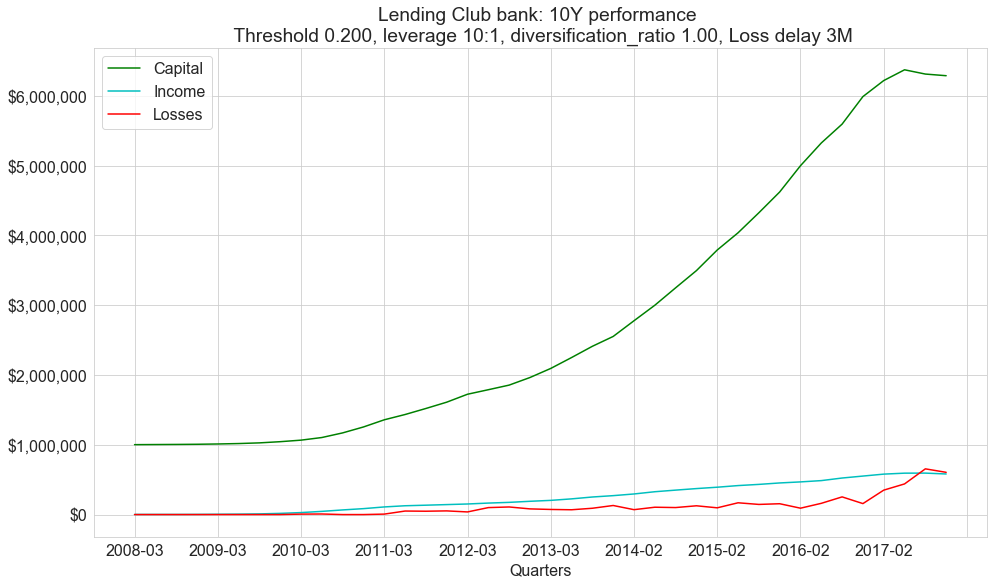

In [31]:
sample_params = {'inv_cycle':           3,
                 'sample_size':         2000,
                 'length_of_run':       120,
                 'sample_df_list':      []
                }

sample_df_list = sample_params['sample_df_list']



start_date = date(2008,1,1)
date_delta = sample_params['inv_cycle'] * 30
date_range = date_delta * sample_params['length_of_run'] / sample_params['inv_cycle']
end_date = start_date+timedelta(date_range)
delta = timedelta(date_delta)


while start_date < end_date:
    # Generate sample from validate set
    invest_horizon = start_date + delta
    sample_df = validate_df.loc[(validate_df['issue_d'] >= start_date) & (validate_df['issue_d'] < invest_horizon)]
    # Score sampled data
    value = clf_core.predict_proba(sample_df[core_features])[:,1]
    sample_df = sample_df.assign(score=value)
    sample_df_list.append(sample_df)
    start_date = invest_horizon

    

    
# Simulate the bank
start_date = date(2008,1,1)
opt_params = {'loss_delay':          3,
              'starting_capital':    1e6,
              'leverage_ratio':      10,
              'loan_interest_rate':  3,
              'threshold':           0.2,
              'diversification_ratio': 1,
              'term_ratio':         10/1,
              'dynamic_management':  False
             }

Bankrupt, result_list = bank_run(start_date, sample_params, opt_params, do_print=True, do_plot=True)
